# Market Making Crypto

### The Challenge
The challange is to crate a Market Making Algorithm using 
binance's datasets as starting point.


#### Project Breakdown

As any complex project, it is easier to tackle if you look as a sequence of smaller problems. So here is the steps I will take:

1. Read and see it: Read the datasets, get an ideia of the format, plot some stuffs.
2. Standardize data: Create a class merging both datasets, with propper attirbutes and methods, to make it easier to handle.
3. Exploratory Analysis: Make some hypothesis, test them, try to make sense with the data and find some predictability.
4. Create the Algo: Create  the MM class using the insights acquired in step 3.

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import glob
import copy

from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

First things, first. Let's take a look in our datasets:

In [2]:
f = open('orderbooks/2020-07-17.json','r')
j = json.load(f)
b = pd.DataFrame(j)

# Worth to set the timestamp as index
b.set_index('lastUpdated', inplace=True)

f.close()

b

,asks,bids
lastUpdated,,
2020-07-17 00:00:23.225,"[[2.644e-05, 5243], [2.645e-05, 4216], [2.646e...","[[2.639e-05, 4216], [2.638e-05, 7000], [2.637e..."
2020-07-17 00:00:30.293,"[[2.645e-05, 4216], [2.646e-05, 763], [2.647e-...","[[2.638e-05, 4989], [2.637e-05, 2427], [2.6360..."
2020-07-17 00:00:30.429,"[[2.645e-05, 4216], [2.646e-05, 763], [2.647e-...","[[2.639e-05, 4216], [2.638e-05, 4989], [2.637e..."
2020-07-17 00:01:04.450,"[[2.644e-05, 11], [2.646e-05, 4978], [2.647e-0...","[[2.639e-05, 4216], [2.638e-05, 6689], [2.637e..."
2020-07-17 00:01:10.753,"[[2.643e-05, 7], [2.645e-05, 3982], [2.646e-05...","[[2.639e-05, 4216], [2.638e-05, 6689], [2.637e..."
...,...,...
2020-07-17 23:52:22.225,"[[2.631e-05, 904], [2.633e-05, 4527], [2.63400...","[[2.628e-05, 17], [2.626e-05, 1210], [2.625e-0..."
2020-07-17 23:52:22.424,"[[2.631e-05, 904], [2.633e-05, 4527], [2.63400...","[[2.629e-05, 4], [2.628e-05, 17], [2.626e-05, ..."
2020-07-17 23:53:21.158,"[[2.631e-05, 904], [2.633e-05, 4527], [2.63400...","[[2.63e-05, 4], [2.629e-05, 4], [2.628e-05, 17..."


Each line of our data is a snapshot of the Limit Order Book, presumible took at each change in the book. One columns is the asks (sell orders), the other the bids (buy orders), with a list of pairs [price, size].

This format may not be the easiest to handle. Lets separete the prices and sizes.

In [3]:
h = pd.DataFrame(columns=['asks_price','asks_qnt', 'bids_price','bids_qnt'], 
                 index=pd.DataFrame(j)['lastUpdated']) # Create a new DataFrame with the lenght of our data.

h.index = pd.to_datetime(h.index) # Convert the Date string to Date formate
for i in range(len(j)):


    for side in ['asks','bids']:

        h.iloc[i][side+'_price'] = list(np.array(ast.literal_eval(j[i][side])).T[0][0:5])
        h.iloc[i][side+'_qnt'] = list(np.array(ast.literal_eval(j[i][side])).T[1][0:5])

In [4]:
h.head()

,asks_price,asks_qnt,bids_price,bids_qnt
lastUpdated,,,,
2020-07-17 00:00:23.225,"[2.644e-05, 2.645e-05, 2.646e-05, 2.647e-05, 2...","[5243.0, 4216.0, 763.0, 1291.0, 15177.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 7000.0, 2427.0, 27936.0, 278.0]"
2020-07-17 00:00:30.293,"[2.645e-05, 2.646e-05, 2.647e-05, 2.648e-05, 2...","[4216.0, 763.0, 6640.0, 16921.0, 62.0]","[2.638e-05, 2.637e-05, 2.6360000000000002e-05,...","[4989.0, 2427.0, 27936.0, 278.0, 2439.0]"
2020-07-17 00:00:30.429,"[2.645e-05, 2.646e-05, 2.647e-05, 2.648e-05, 2...","[4216.0, 763.0, 6640.0, 16921.0, 62.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 4989.0, 2427.0, 27936.0, 278.0]"
2020-07-17 00:01:04.450,"[2.644e-05, 2.646e-05, 2.647e-05, 2.648e-05, 2...","[11.0, 4978.0, 1291.0, 8677.0, 5546.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 6689.0, 7998.0, 27936.0, 278.0]"
2020-07-17 00:01:10.753,"[2.643e-05, 2.645e-05, 2.646e-05, 2.647e-05, 2...","[7.0, 3982.0, 4978.0, 1291.0, 8677.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 6689.0, 2427.0, 27936.0, 278.0]"


Let's turn our attention to the trades file.

I replace the buy/sell string for 1 or -1, respectively, in case I decide to use it in a regression or something else.


In [5]:
trades =  pd.read_csv('trades.csv', usecols = ['timestamp', 'id', 'price', 'side', 'amount'])
trades.loc[trades['side'] == 'buy', 'side'] = 1
trades.loc[trades['side'] == 'sell', 'side'] = -1
trades.rename(columns={'timestamp':'lastUpdated'}, inplace=True)
trades.set_index('lastUpdated', inplace=True)
trades.index = pd.to_datetime(trades.index)
trades

,id,price,side,amount
lastUpdated,,,,
2020-07-17 00:01:10.647,19088200,0.000026,1,4.0
2020-07-17 00:01:26.820,19088201,0.000026,-1,58.0
2020-07-17 00:01:26.825,19088202,0.000026,-1,25.0
2020-07-17 00:01:26.841,19088203,0.000026,-1,235.0
2020-07-17 00:01:26.842,19088204,0.000026,-1,36.0
...,...,...,...,...
2020-07-30 23:54:05.293,19187367,0.000027,-1,181.0
2020-07-30 23:57:25.885,19187368,0.000027,1,167.0
2020-07-30 23:58:00.690,19187369,0.000027,-1,21.0


The challange now is to merge both datasets and treat them as one thing. The difficult is that the trades and LOB snapshots are not perfectly time aligned. If our LOB data is not missing anything, we can assume that the LOB associated to a given trade is the last one that happend before the trade.

In [6]:
## Pandas function to merge based on timestamp
merged = pd.merge_asof(h, trades, left_index=True, right_index=True, 
                        direction='backward', allow_exact_matches=False)

# merge_asof has an undesired property to fill all previous lines with the same trade values, until
# a previous trade happend. This code replace repetitions with NA.
merged['dupli'] = merged['id'].shift(1)
lis = ['price','side','amount','id']

for c in lis:

    merged[c] = merged.apply(lambda x: float('NaN') if x['id'] == x['dupli'] else x[c], axis=1)

merged = merged.drop(['dupli','id'], axis=1)

##

merged


,asks_price,asks_qnt,bids_price,bids_qnt,price,side,amount
lastUpdated,,,,,,,
2020-07-17 00:00:23.225,"[2.644e-05, 2.645e-05, 2.646e-05, 2.647e-05, 2...","[5243.0, 4216.0, 763.0, 1291.0, 15177.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 7000.0, 2427.0, 27936.0, 278.0]",NaN,NaN,NaN
2020-07-17 00:00:30.293,"[2.645e-05, 2.646e-05, 2.647e-05, 2.648e-05, 2...","[4216.0, 763.0, 6640.0, 16921.0, 62.0]","[2.638e-05, 2.637e-05, 2.6360000000000002e-05,...","[4989.0, 2427.0, 27936.0, 278.0, 2439.0]",NaN,NaN,NaN
2020-07-17 00:00:30.429,"[2.645e-05, 2.646e-05, 2.647e-05, 2.648e-05, 2...","[4216.0, 763.0, 6640.0, 16921.0, 62.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 4989.0, 2427.0, 27936.0, 278.0]",NaN,NaN,NaN
2020-07-17 00:01:04.450,"[2.644e-05, 2.646e-05, 2.647e-05, 2.648e-05, 2...","[11.0, 4978.0, 1291.0, 8677.0, 5546.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 6689.0, 7998.0, 27936.0, 278.0]",NaN,NaN,NaN
2020-07-17 00:01:10.753,"[2.643e-05, 2.645e-05, 2.646e-05, 2.647e-05, 2...","[7.0, 3982.0, 4978.0, 1291.0, 8677.0]","[2.639e-05, 2.638e-05, 2.637e-05, 2.6360000000...","[4216.0, 6689.0, 2427.0, 27936.0, 278.0]",0.000026,1.0,4.0
...,...,...,...,...,...,...,...
2020-07-17 23:52:22.225,"[2.631e-05, 2.633e-05, 2.6340000000000002e-05,...","[904.0, 4527.0, 627.0, 6619.0, 5522.0]","[2.628e-05, 2.626e-05, 2.625e-05, 2.624e-05, 2...","[17.0, 1210.0, 10618.0, 8182.0, 10693.0]",0.000026,-1.0,4.0
2020-07-17 23:52:22.424,"[2.631e-05, 2.633e-05, 2.6340000000000002e-05,...","[904.0, 4527.0, 627.0, 6619.0, 7687.0]","[2.629e-05, 2.628e-05, 2.626e-05, 2.625e-05, 2...","[4.0, 17.0, 1210.0, 10618.0, 8182.0]",NaN,NaN,NaN
2020-07-17 23:53:21.158,"[2.631e-05, 2.633e-05, 2.6340000000000002e-05,...","[904.0, 4527.0, 627.0, 6619.0, 7687.0]","[2.63e-05, 2.629e-05, 2.628e-05, 2.626e-05, 2....","[4.0, 4.0, 17.0, 3.0, 4988.0]",NaN,NaN,NaN


Having seen the data, we are rady to create a Class for it. The intention of this class is not only to merge both files in a single object, but also have usefull methods each extract important informations from the data.

In [7]:
##### Class LOB #####


# Let's create a Class for our LOB data!!!
# The Market depth in the data may be much more than the analyst may want, 
# therefore I decided to let the user choose the market depth to keep.



class LOB():


    def __init__(self, lobData, tradesData, depth = 5): # depth is the number of the levels in the book to keep.

        self.lob = lobData
        self.tdata = tradesData
        self.parseLOB()
        self.parseTrades()
        self.syncData()

    ##### Internal Methods #####

    def parseLOB(self): # Parse the orderbook

        js = []
        for file in self.lob:
            with open(file, 'r') as f:
                j = json.load(f)
                js.extend(j)
        
        self.book = pd.DataFrame(columns=['asks_price','asks_qnt', 'bids_price','bids_qnt'], 
                                  index=pd.DataFrame(js)['lastUpdated'])
        self.book.rename(columns={'lastUpdated':'timestamp'}, inplace=True) 

        # Split the price and size
        for i in range(len(js)):
            for side in ['asks','bids']:

                self.book.iloc[i][side+'_price'] = list(np.array(ast.literal_eval(js[i][side])).T[0])
                self.book.iloc[i][side+'_qnt'] = list(np.array(ast.literal_eval(js[i][side])).T[1])
        
        self.book.index = pd.to_datetime(self.book.index)


    def parseTrades(self): # Parse the trades data

        self.trades = pd.read_csv(self.tdata, usecols = ['timestamp', 'id', 'price', 'side', 'amount'])
        self.trades.loc[self.trades['side'] == 'buy', 'side'] = 1
        self.trades.loc[self.trades['side'] == 'sell', 'side'] = -1
        
        self.trades.set_index('timestamp', inplace=True)
        self.trades.index = pd.to_datetime(self.trades.index)


    def syncData(self): #Synchronize both sets
        
        # In case um set is longer term than the other, reduce the same last time.
        dateLimit = min(max(self.trades.index),max(self.book.index))
        self.trades = self.trades[self.trades.index < dateLimit]
        self.book = self.book[self.book.index < dateLimit]

        #merge
        self.fullData = pd.merge_asof(self.book, self.trades, left_index=True, right_index=True, direction='backward', allow_exact_matches=False)
        self.fullData['dupli'] = self.fullData['id'].shift(1)
        lis = ['price','side','amount','id']

        for c in lis:

            self.fullData[c] = self.fullData.apply(lambda x: float('nan') if x['id'] == x['dupli'] else x[c], axis=1)

        self.fullData = self.fullData.drop(['dupli','id'], axis=1)
        


    ##### External Methods #####
    # This methods should provide usefull, frequently needed, informations derived from our data.

    def priceByLevel(self, level=0): # Get the bid/ask price at each market level

        return pd.DataFrame({'asks': self.book.asks_price.apply(lambda x: x[level]), 
                    'bids': self.book.bids_price.apply(lambda x: x[level])})


    def qntByLevel(self, level=0): # Get the bid/ask size at each market level

        return pd.DataFrame({'asks': self.book.asks_qnt.apply(lambda x: x[level]), 
                    'bids': self.book.bids_qnt.apply(lambda x: x[level])})


    def spread(self, level = 0): # The difference between bid and ask price at each level
        
        return self.priceByLevel(level).asks - self.priceByLevel(level).bids


    def midPrice(self): # Mid-price, i.e. average between bid and ask

        return (self.priceByLevel(level=0).asks+self.priceByLevel(level=0).bids)/2


    def wap(self, cross = False):
    
        # The Weighted Average Price measure the "mid-price" taking account the size at each size of the book.
        # I found two definitions: one weights each side (best order) by its own size, 
        # the other weights by the opposite side size. Let the user choose.
        # Counterintuitive at first side, the crossed definition also make sense.
        # A bigger Ask order is expected to push price to the Bid side, 
        # therefore, seems reseonable to the mid-price be skewed to the bid price 
        # (the same for the opposite situation).

        if (cross == False):

            return ((self.priceByLevel(level=0).asks * self.qntByLevel(level=0).asks + 
                    self.priceByLevel(level=0).bids * self.qntByLevel(level=0).bids)/
                    (self.qntByLevel(level=0).asks + self.qntByLevel(level=0).bids))

        else:

            return ((self.priceByLevel(level=0).asks * self.qntByLevel(level=0).bids + 
                    self.priceByLevel(level=0).bids * self.qntByLevel(level=0).asks)/
                    (self.qntByLevel(level=0).asks + self.qntByLevel(level=0).bids))



    def OFI(self):

        # This function is based on the paper "The price impact of order book events."
        # by Rama Cont, Arseniy Kukanov, and Sasha Stoikov.
        # The "en" is a measuremente of changes in the book in qunatities, based on changes of bid and ask. 
        # A positive number indicates a increase in demand, therefore should predict a price increase.


        self.fullData['i'] = np.arange(len(self.fullData))
        en = np.zeros(len(self.fullData))
        ofi = np.zeros(len(self.fullData))
        dpk = np.zeros(len(self.fullData))

        en[0] = 0
        ofi[0] = 0
        dpk[0] = float('NaN')
        
        pk = self.midPrice()[0]
        
        # Cont et al. used only Level 1 orders, but I think that crypto markets have many small traders
        # placing small uninformed orders at L1, without significantly informing about supply/demand. polluting 
        # the measurement. I used the weighted average between L1 and L2 price and the sum of quantities
        # to smooth this effect. 
        # Its tempting to use many levels here, but orders far from the L1 may be deceiving, used to hold place
        # in the queue or deceive algotraders.
        #
        # The "ofi" is the "Order Flow Imbalance", the summation of "en"s between each trading occorrence.
        #
        # The "DeltaPrice" is simple the diference between one execution price of a trade and the previous one.

        qnt = (self.qntByLevel(0)+self.qntByLevel(1))
        price = ((self.priceByLevel(0)*self.qntByLevel(0)+self.priceByLevel(1)*self.qntByLevel(1))
                /(self.qntByLevel(0)+self.qntByLevel(1)))

        for i in range(len(en)-1):
    
            en[i+1] = ((qnt.bids[i+1] if price.bids[i+1] >= price.bids[i] else 0) -
                        (qnt.bids[i] if price.bids[i+1] <= price.bids[i] else 0) -
                        (qnt.asks[i+1] if price.asks[i+1] <= price.asks[i] else 0) +
                        (qnt.asks[i] if price.bids[i+1] >= price.bids[i] else 0))

            if (pd.isna(self.fullData.price[i])):
                ofi[i+1] = ofi[i] + en[i+1]
                dpk[i+1] = float('NaN')
            else:
                ofi[i+1] = en[i+1]
                
        
        for i in range(len(en)):

            if (pd.isna(self.fullData.price[i])):
                dpk[i] = float('NaN')
            else:
                dpk[i] =(self.fullData.price[i]-pk)

                pk =  copy.deepcopy(self.fullData.price[i])

        dpk[-1] = self.midPrice()[-1]

        return pd.DataFrame([en,ofi,dpk], index=['En','OFI','DeltaPrice'], columns=self.fullData.index).T


Data Class done. Let's focus our attention in decide at which prices we should place our bid and ask orders based in the data.

We can split the task in:
    - Predict the price direction
    - Predict the spread size.

Our prices will be predictedPrice +|- spread/2

First, let's create a object with a few dates of data.

In [8]:
#json_file_list = glob.glob('orderbooks/*.json')  # In case you want to open all the files in the folder
json_file_list = ['orderbooks/2020-07-22.json','orderbooks/2020-07-23.json',
                    'orderbooks/2020-07-24.json','orderbooks/2020-07-25.json']
market = LOB(json_file_list,'trades.csv', 5)

Let's look to the best bids, asks and spread through time (ploting every nth datapoint for speed).

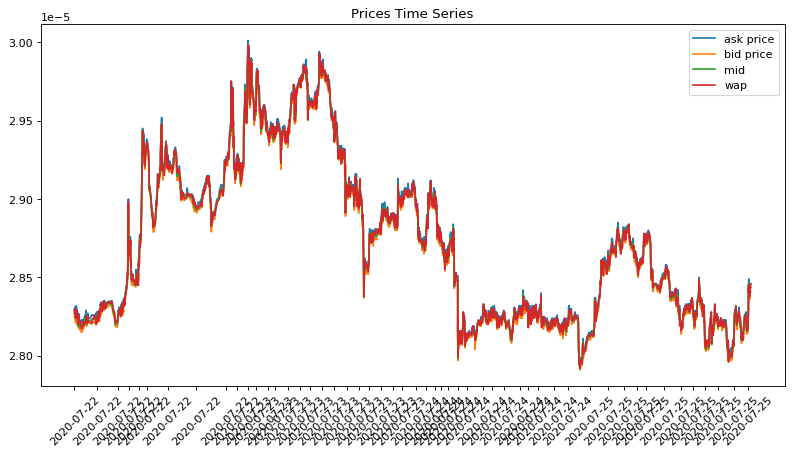

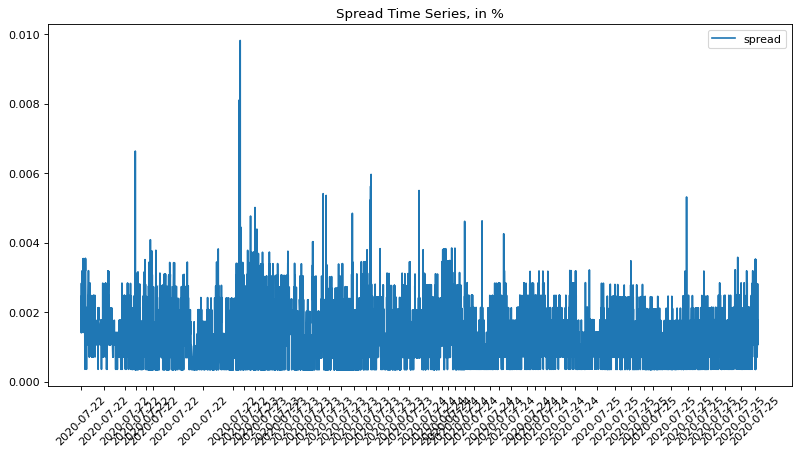

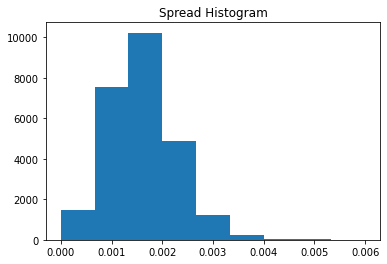

In [23]:
firstLevel = market.priceByLevel(level=0)
midP = market.midPrice()
spread = (firstLevel.asks-firstLevel.bids)/midP

n = 10

plt.figure(figsize=(12, 6), dpi=80)
plt.title('Prices Time Series')
plt.plot(firstLevel[0::n], label=['ask price','bid price'])
plt.plot(market.midPrice()[0::n], label='mid')
plt.plot(market.wap()[0::n], label='wap')
plt.legend(loc = "upper right")
plt.xticks(firstLevel.index[0::500], rotation = 45)
plt.savefig('hist.png')
plt.show()


plt.figure(figsize=(12, 6), dpi=80)
plt.title('Spread Time Series, in %')

plt.plot(spread, label = 'spread')
plt.legend(loc = "upper right")
plt.xticks(firstLevel.index[0::500], rotation = 45)
plt.savefig('histSpread.png')
plt.show()

# And spread histogram, which looks pretty symmetrical, even binomialy distributed.
plt.title('Spread Histogram')
plt.hist(spread, bins=np.linspace(0,0.006,10))
plt.savefig('histHist.png')
plt.show()


The first thing to caught our attention is the tightness of the spread, usually less than 0.3%. Make market here won't be a easy taks.

The second thing is a apparently mean-reversion in the process. We can check this hypothesis using the Augmented Dickey-Fuller test.

In [10]:
adf_spread = adfuller(spread,20)
print('ADF Statistic: %f' % adf_spread[0])
print('p-value: %f' % adf_spread[1])
print('Critical Values:')
for key, value in adf_spread[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.316745
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


With an ADF Statistic way bellow the 1% critical value, we can safely reject the stationarity hyposthesis and proceed with the mean-reversion idea.

This make sense with economic theory. If the spread gets too wide, players enter in the market to harvest the opportunity, narrowing it. If it's too narrow, the less efficient players are forced out the market, widening the spread.

Let's check the first difference of the spread series to check for further predictibilty.

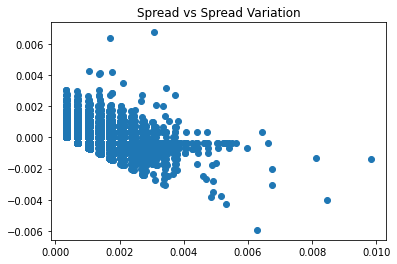

In [25]:
spread_variation = spread.diff()[1:]

plt.title('Spread vs Spread Variation')
plt.scatter(spread[:-1],spread_variation[:])
plt.savefig('OUrev.png')
plt.show()


In [12]:
# Linear Regression between the spread and its first difference

regSpread = LinearRegression().fit(np.array(spread[:-1]).reshape(-1, 1),np.array(spread_variation[:]).reshape(-1, 1))
print("R-Squared:", regSpread.score(np.array(spread[:-1]).reshape(-1, 1),np.array(spread_variation[:]).reshape(-1, 1)))
print("Beta:", regSpread.coef_[0][0])
print("Intercept:", regSpread.intercept_[0])

R-Squared: 0.1989116159743498
Beta: -0.3978255287484387
Intercept: 0.0005999952904138282


The two cells above indicate a strong relation between the spread and its subsequent variation. In the next we going to test the spread variation against its lags, removed the level of the spread effect.

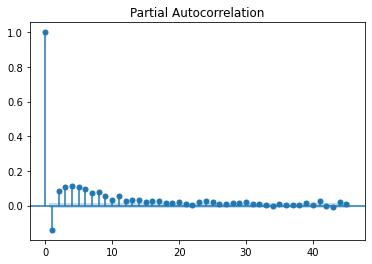

In [26]:
e_spread_variation = spread_variation.values - (regSpread.intercept_[0] + regSpread.coef_[0][0] * spread.values[:-1])

# Partial Autocorrelation of Spread Variation

tsaplots.plot_pacf(e_spread_variation, alpha=0.01);
plt.savefig('pacf.png')

In [14]:
# AR (autoregressive) model with Lag=3
ar_model1 = AutoReg(e_spread_variation, lags=1).fit()
print(ar_model1.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                25630
Model:                     AutoReg(1)   Log Likelihood              156706.359
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Thu, 25 Aug 2022   AIC                            -15.066
Time:                        22:00:09   BIC                            -15.066
Sample:                             1   HQIC                           -15.066
                                25630                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.287e-08   3.34e-06     -0.013      0.990   -6.59e-06    6.51e-06
y.L1          -0.1404      0.006    -22.697      0.000      -0.152      -0.128
                                    Roots           

C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [15]:
# AR (autoregressive) model with Lag=10
ar_model10 = AutoReg(e_spread_variation, lags=10).fit()
print(ar_model10.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                25630
Model:                    AutoReg(10)   Log Likelihood              157515.850
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Thu, 25 Aug 2022   AIC                            -15.133
Time:                        22:00:09   BIC                            -15.129
Sample:                            10   HQIC                           -15.132
                                25630                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.946e-08   3.23e-06     -0.021      0.983    -6.4e-06    6.26e-06
y.L1          -0.1901      0.006    -30.434      0.000      -0.202      -0.178
y.L2           0.0391      0.006      6.162      0.0

C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


The Spread Variation (net of the previous spread relationship) is curiously negative related with the previous spread and positive related with lags >= 1 until at least lag = 10. Altough the Z-score shows a statistically significant relation up the 10th lag, the log-likelihood, AIC and BIC show little improvement, let's keep lags = 1.

In [16]:
spread_predic = (-regSpread.intercept_[0] + -regSpread.coef_[0][0] * spread.values[3:-1] 
                    + e_spread_variation[1:-2] * ar_model1.params[1])

R^2: 0.20818961037566855


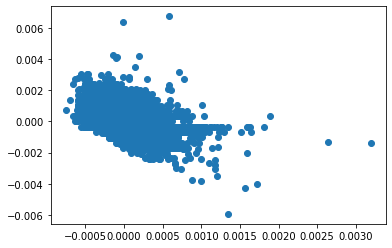

In [17]:
plt.scatter(spread_predic,spread_variation[3:])
rsq = (np.corrcoef(spread_predic,spread_variation[3:])[0][1])**2
print('R^2:', rsq)

Having a model for predicting the spread, I will change our focus to the prediction of price. This model will be based on the Cont et al. paper mentioned in the LOB Class.

Let's take a look in our data.

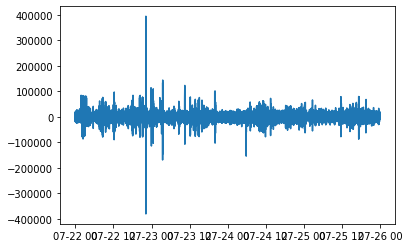

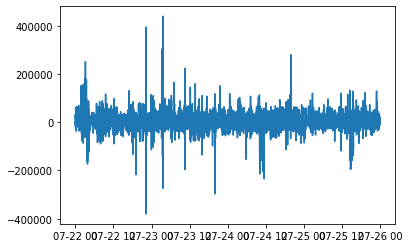

In [27]:
plt.plot(market.OFI().En)
plt.savefig('en.png')
plt.show()

plt.plot(market.OFI().OFI)
plt.savefig('ofi.png')
plt.show()

In [19]:
# Looking OFI and DeltaPrice when a trade occour

OFI_trade = market.OFI()[market.OFI().DeltaPrice.notnull()]
OFI_trade = OFI_trade[np.abs(OFI_trade.DeltaPrice-OFI_trade.DeltaPrice.mean()) <= (3*OFI_trade.DeltaPrice.std())] # Removing outliers
OFI_trade = OFI_trade[np.abs(OFI_trade.OFI-OFI_trade.OFI.mean()) <= (2*OFI_trade.OFI.std())] # Removing outliers

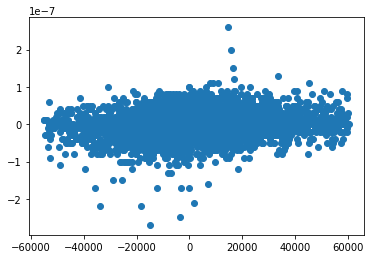

Correlation between OFI and DeltaPrice:  0.22054918674391108


In [28]:
plt.scatter(OFI_trade.OFI,OFI_trade.DeltaPrice)
plt.savefig('ofidelta.png')
plt.show()

print('Correlation between OFI and DeltaPrice: ',np.corrcoef(OFI_trade.OFI,OFI_trade.DeltaPrice)[0][1])

A linear regression, again, seems a resonable model for a first analysis.

In [32]:
X2 = sm.add_constant(OFI_trade.OFI.values.reshape(-1, 1))
est = sm.OLS(OFI_trade.DeltaPrice,X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             DeltaPrice   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     389.5
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           1.34e-84
Time:                        16:06:01   Log-Likelihood:             1.2162e+05
No. Observations:                7620   AIC:                        -2.432e+05
Df Residuals:                    7618   BIC:                        -2.432e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.353e-10   3.27e-10     -2.557      0.0

In [21]:
regPrice = LinearRegression()
regPrice.fit(OFI_trade.OFI.values.reshape(-1, 1),OFI_trade.DeltaPrice)
print('R^2: ',regPrice.score(OFI_trade.OFI.values.reshape(-1, 1),OFI_trade.DeltaPrice))
print('Regression Beta: ',regPrice.coef_[0])
print('Regression Intercept: ', regPrice.intercept_)

R^2:  0.04864194377340059
Regression Beta:  3.5279187855684965e-13
Regression Intercept:  -8.353417597654075e-10


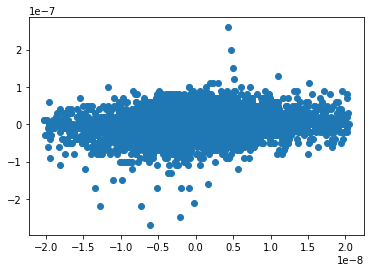

R^2:  0.04864194377340055


In [33]:
predicPrice = OFI_trade.OFI.values * regPrice.coef_ + regPrice.intercept_
plt.scatter(predicPrice, OFI_trade.DeltaPrice)
plt.savefig('ofireg.png')
plt.show()
print('R^2: ', (np.corrcoef(predicPrice, OFI_trade.DeltaPrice)[0][1])**2)

In a competitive market, predict the price is not an easy task, therefore a R^2 of ~5% it's actually an interesting number.

We now have the tools to build our actual Market Maker algo.

The Market Maker Class will receive three vector of informations: tradingParams, marketParams, predictionParams.

Each with the following:

tradingParams:

    - currentPosition: Our current position in Crypto.
    - desiredPosition: The desired position in Crypto. It could be 0 for a neutral futures trader or a positive value for a trader allowed to have an inventory.
    - averageSize: The average desired trade size (more details in the class).
    - lotSize: Some markets only allow sizes multiples of a number.
    - decayFactor: A factor to adjust the order size (more details in the class).

marketParams:

    - spreadVector: Vector of past spreads.
    - currentOFI: Last OFI value.
    - lastPrice: Last Executed Price


predictionParams:

    - ofiIntercept: Intercept of the price prediction model.
    - ofiBeta: Beta of the price prediction model.
    - spreadIntercept: Intercept of the Spread vs Spread variation Model
    - spreadBeta: Beta of the Spread vs Spread variation Model
    - arBeta: Beta of the Autoregressive Model

shortSellAllowed: Indicate if this market allowed short positions.

In [117]:
#tradingParams = ['currentPosition','desiredPosition','averageSize','lotSize','decayFactor']
#marketParams = ['spreadVector','currentOFI', 'lastPrice']
#predictionParams = ['ofiIntercept','ofiBeta','spreadIntercept','spreadBeta','arBeta']

In [118]:
class marketMaker():

    def __init__(self, tradingParams, marketParams, predictionParams, shortSellAllowed = False):

        self.tradingParams = tradingParams
        self.marketParams = marketParams
        self.predictionParams = predictionParams
        self.shortSellAllowed = shortSellAllowed

    def update(self, tradingParams, marketParams, predictionParams):

        self.tradingParams = tradingParams
        self.marketParams = marketParams
        self.predictionParams = predictionParams

    def prediSpread(self):

        spread = self.marketParams[0]
        spreadPredic = (self.predictionParams[2] + self.predictionParams[3] * spread[-1] +
                        (spread[-1] - spread[-2]) * self.predictionParams[4]) * self.marketParams[2]

        return spreadPredic

    def prediPrice(self):
        
        price = self.marketParams[2] + self.predictionParams[0] + self.predictionParams[1] * self.marketParams[1]

        return price

    def prices(self):
        
        # Consider the predicted price as a prediction of the mid price.

        bid = self.prediPrice() - self.prediSpread()*0.5
        ask = self.prediPrice() + self.prediSpread()*0.5
        
        return [bid, ask]

    def size(self):

        # Altough the challange suggests a fixed order size, I have tried to make a simple MM algo
        # before (rule: 1 bip worst than the current best bid/offer), connected to an exchange.
        # Was usual to my position grows many times to one side or another, reaching my margin limit
        # and forcing me to liquidate part of the position, at big loss. This issue was partially solved
        # by adjust the bid/ask sizes according to my current position. If I have more than desired,
        # buy less than sell and vice-versa.
        #
        # The choosed functional form is a discretized exponential decay:
        bidSize = ((tradingParams[2]*np.exp((tradingParams[0] - tradingParams[1])*(1/tradingParams[2])*-tradingParams[4]))// tradingParams[3]) * tradingParams[3]
        askSize = ((tradingParams[2]*np.exp((tradingParams[1] - tradingParams[0])*(1/tradingParams[2])*-tradingParams[4]))// tradingParams[3]) * tradingParams[3]

        if not(self.shortSellAllowed):
            askSize = min(askSize, tradingParams[0])

        return [bidSize, askSize]

    def createOrder(self):

        # A sequential orderd id is usefull to keep track of each trade creation for subsequent
        # order modification, cancelation and record.

        global od_id


        price = self.prices()
        qnt = self.size()

        # Order Type: Limit Good-Til-Cancel Post Only (if the price would cause a immediatly execution, the
        # price is worstened in 1 bip)
        bidOrder = ({'order id:': od_id+1, 'side:' : 'buy', 'order_type:': 'Limit GTC Post-Only', 'price:': price[0], 'quantity:': qnt[0]})
        askOrder = ({'order id:': od_id+2, 'side:' : 'sell', 'order_type:': 'Limit GTC Post-Only', 'price:': price[1], 'quantity:': qnt[1]})

        
        od_id = od_id + 2

        return [bidOrder, askOrder]




In [119]:
tradingParams = [100000,100000,1000,1,0.01]
marketParams = [spread.values,OFI_trade.OFI[-1], market.trades.price[-1]]
predictionParams = [regPrice.intercept_,regPrice.coef_[0],regSpread.intercept_[0],regSpread.coef_[0][0],ar_model1.params[1]]

In [120]:
robot = marketMaker(tradingParams, marketParams, predictionParams)
od_id = 0

In [121]:
robot.createOrder()

[{'order id:': 1,
  'side:': 'buy',
  'order_type:': 'Limit GTC Post-Only',
  'price:': 2.8471355815240297e-05,
  'quantity:': 1000.0},
 {'order id:': 2,
  'side:': 'sell',
  'order_type:': 'Limit GTC Post-Only',
  'price:': 2.8465712623066205e-05,
  'quantity:': 1000.0}]

In [122]:
tradingParams = [90000,100000,1000,1,0.01]
marketParams = [spread.values,OFI_trade.OFI[-1], market.trades.price[-1]]
predictionParams = [regPrice.intercept_,regPrice.coef_[0],regSpread.intercept_[0],regSpread.coef_[0][0],ar_model1.params[1]]

robot.update(tradingParams, marketParams, predictionParams)
robot.createOrder()

[{'order id:': 3,
  'side:': 'buy',
  'order_type:': 'Limit GTC Post-Only',
  'price:': 2.8471355815240297e-05,
  'quantity:': 1105.0},
 {'order id:': 4,
  'side:': 'sell',
  'order_type:': 'Limit GTC Post-Only',
  'price:': 2.8465712623066205e-05,
  'quantity:': 904.0}]